<p><img alt="UNQ logo" height="45px" width="115px" src="https://sobrelibrosycultura.com/wp-content/uploads/2016/09/quilmes-1.jpg
" align="left" hspace="10px" vspace="0px"></p><h1>Redes Neuronales y Lógica Difusa</h1>

# Resolución de problema de gas con scikit-learn



In [ ]:
!pip install scikit-learn

In [ ]:
!git clone https://github.com/redes-unq/mDataFiles.git

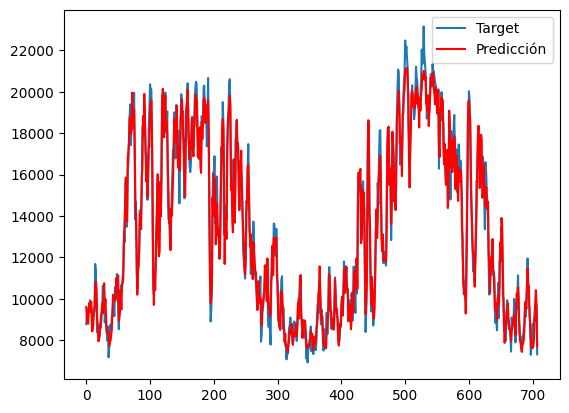

Error medio absoluto: 576.499307933886
RMSE (Train): 745.564032600611
RMSE (Test): 741.5085865926964


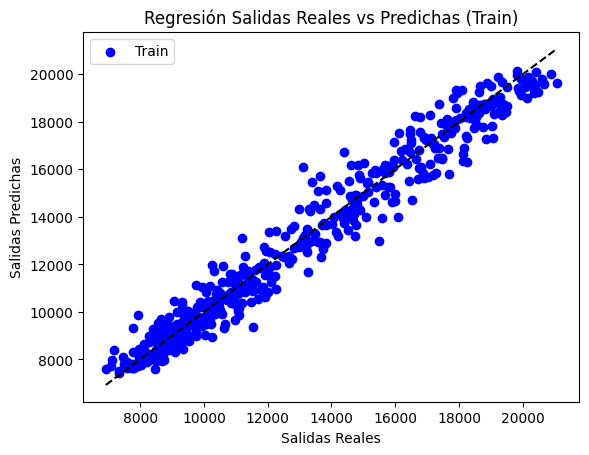

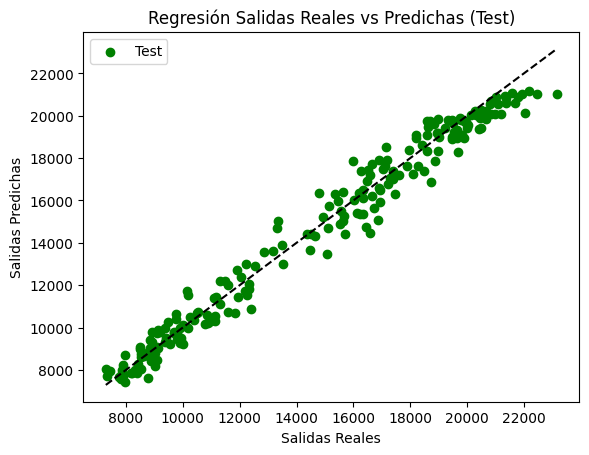

In [4]:
import numpy as np
from scipy.io import loadmat
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargo el archivo de datos
data = loadmat('mDataFiles/datos_guia4_ej6_gas.mat')

# Asigno los vectores de entrada y de target en base al archivo MAT
p = data['temp'].flatten()
t = data['consumof'].flatten()

p = p[20:]
t = t[20:]

# Armo mi matriz de entradas donde cada fila esta compuesta por las
# temperaturas de los ultimos 2 dias y la predicción del día próximo.
P = []
T = []

for i in range(2, len(p)):
    #P.append([p[i-1], p[i-2], t[i-1]])
    #P.append([p[i-1], t[i-1]])
    P.append([p[i-1], p[i]+np.random.normal(loc=0, scale=2)])
    T.append(t[i])

P = np.array(P)
T = np.array(T)

# Normalización de las entradas y salidas
# El StandardScaler de scikit-learn estándariza las características eliminando la media
# y escalando a la desviación estándar unitaria. La fórmula que aplica a cada característica es:
# z=(x−μ)/σ​
# donde:
#     x es el valor de la característica original.
#     μ es la media de la característica.
#     σ es la desviación estándar de la característica.

scaler_p = StandardScaler()
scaler_t = StandardScaler()

P = scaler_p.fit_transform(P)
T = scaler_t.fit_transform(T.reshape(-1, 1)).flatten()

# División de los datos en entrenamiento, validación y test
train_size = int(0.7 * len(P))
val_size = int(0.0 * len(P))
test_size = len(P) - train_size - val_size

P_train = P[:train_size]
T_train = T[:train_size]

P_val = P[train_size:train_size + val_size]
T_val = T[train_size:train_size + val_size]

P_test = P[train_size + val_size:]
T_test = T[train_size + val_size:]

# Combinar los datos de entrenamiento y validación para usar en early stopping
P_train_val = np.concatenate((P_train, P_val), axis=0)
T_train_val = np.concatenate((T_train, T_val), axis=0)

#'logistic', 'tanh', 'identity', 'relu'
# Creación y configuración de la red neuronal con early stopping
net = MLPRegressor(hidden_layer_sizes=(5,), activation='logistic', max_iter=1000, learning_rate_init=0.2, tol=1e-9,
                   early_stopping=True, validation_fraction=0.3, n_iter_no_change=10)

#net = MLPRegressor(hidden_layer_sizes=(10,), activation='logistic', max_iter=1000, learning_rate_init=0.2, tol=1e-9,
#                   early_stopping=True, validation_fraction=0.3, n_iter_no_change=10)



# Entrenamiento de la red
net.fit(P_train_val, T_train_val)

# Simulación y evaluación de la red entrenada
a = net.predict(P)

# Desnormalizar las salidas para la evaluación
T_denorm = scaler_t.inverse_transform(T.reshape(-1, 1)).flatten()
a_denorm = scaler_t.inverse_transform(a.reshape(-1, 1)).flatten()

# Graficar los resultados
plt.figure()
plt.plot(T_denorm, label='Target')
plt.plot(a_denorm, 'r', label='Predicción')
plt.legend()
plt.show()

# Error medio absoluto
mean_absolute_error = np.mean(np.abs(T_denorm - a_denorm))
print('Error medio absoluto:', mean_absolute_error)

# Predicciones para los conjuntos de entrenamiento y prueba
a_train = net.predict(P_train)
a_test = net.predict(P_test)

# Desnormalizar las predicciones
T_train_denorm = scaler_t.inverse_transform(T_train.reshape(-1, 1)).flatten()
T_test_denorm = scaler_t.inverse_transform(T_test.reshape(-1, 1)).flatten()
a_train_denorm = scaler_t.inverse_transform(a_train.reshape(-1, 1)).flatten()
a_test_denorm = scaler_t.inverse_transform(a_test.reshape(-1, 1)).flatten()

# Calcular el RMSE para el conjunto de entrenamiento y prueba
rmse_train = np.sqrt(mean_squared_error(T_train_denorm, a_train_denorm))
rmse_test = np.sqrt(mean_squared_error(T_test_denorm, a_test_denorm))

print('RMSE (Train):', rmse_train)
print('RMSE (Test):', rmse_test)

# Graficar la regresión de las salidas reales vs las predichas para el conjunto de entrenamiento
plt.figure()
plt.scatter(T_train_denorm, a_train_denorm, color='blue', label='Train')
plt.plot([min(T_train_denorm), max(T_train_denorm)], [min(T_train_denorm), max(T_train_denorm)], 'k--')
plt.xlabel('Salidas Reales')
plt.ylabel('Salidas Predichas')
plt.title('Regresión Salidas Reales vs Predichas (Train)')
plt.legend()
plt.show()

# Graficar la regresión de las salidas reales vs las predichas para el conjunto de prueba
plt.figure()
plt.scatter(T_test_denorm, a_test_denorm, color='green', label='Test')
plt.plot([min(T_test_denorm), max(T_test_denorm)], [min(T_test_denorm), max(T_test_denorm)], 'k--')
plt.xlabel('Salidas Reales')
plt.ylabel('Salidas Predichas')
plt.title('Regresión Salidas Reales vs Predichas (Test)')
plt.legend()
plt.show()
